# SBI-DELTA with Enhanced Simulator

This notebook demonstrates how to use the `EnhancedSBISimulator`, which treats detection filter characteristics (center wavelengths, bandwidths) as parameters to be inferred alongside fluorophore concentrations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import sys


# Import the multiplex_sim package
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap
sys.path.append('..')

from multiplex_sim import (
    list_fluorophores, plot_fluorophores,
)
from multiplex_sim.sbi_simulator_with_filters import (
    EnhancedSBIConfig, EnhancedSBISimulator, create_enhanced_sbi_simulator
)    

from multiplex_sim.prior_visualization import PriorVisualizer
from sbi.inference import SNPE
from sbi.analysis import pairplot

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Select Fluorophores

We'll start by selecting the fluorophores for our experiment and visualizing their spectra.

Selected fluorophores for multiplexing: ['Rhodamine 110 - ', 'JF525', 'JF552', 'JF608', 'JFX673']


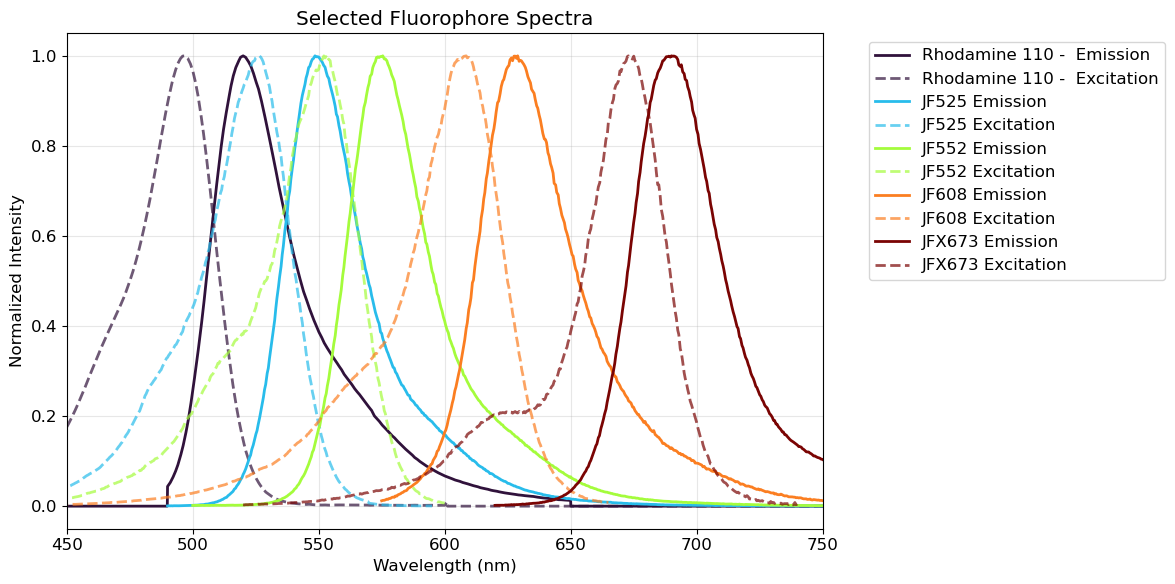

In [64]:
# Define the fluorophores for the experiment
fluorophore_names = ['Rhodamine 110 - ', 'JF525','JF552', 'JF608', 'JFX673']
print(f"Selected fluorophores for multiplexing: {fluorophore_names}")

# Plot their spectra
plot_fluorophores(fluorophore_names, "../data/spectra_npz", normalize=True)
plt.title("Selected Fluorophore Spectra")
plt.xlim(450, 750)  # Set x-axis limits for better visibility
plt.show()

## 2. Configure the Enhanced SBI Simulation

Here, we configure the simulation to include filter parameters in the inference process. We'll use 8 detection channels and the `tile_peaks` strategy to center the filter priors around the fluorophore emission peaks.

In [75]:
sbi_config = EnhancedSBIConfig(
    n_channels=7,
    wavelength_range=(450, 850),
    total_dye_photons=1500.0,
    total_background_photons=20.0,
    include_filter_params=True,  # Key setting for enhanced simulation
    include_background_params=True,
    center_wavelength_distribution='tile_peaks',  # Use peak-based prior
    peak_centered_std=20.0,  # Std deviation for center wavelength prior
    bandwidth_bounds=(5, 30),
    random_seed=42
)

print("Enhanced SBI Configuration:")
print(f"  Number of fluorophores: {len(fluorophore_names)}")
print(f"  Number of channels: {sbi_config.n_channels}")
print(f"  Center wavelength distribution: '{sbi_config.center_wavelength_distribution}'")

Enhanced SBI Configuration:
  Number of fluorophores: 5
  Number of channels: 7
  Center wavelength distribution: 'tile_peaks'


## 3. Create the Simulator

Now we instantiate the `EnhancedSBISimulator` with our configuration.

In [76]:
simulator = EnhancedSBISimulator(
    fluorophore_names=fluorophore_names,
    spectra_dir="../data/spectra_npz",
    config=sbi_config
)

print(f"Created Enhanced SBI simulator.")
print(f"Total parameters to infer: {simulator.total_params}")

ADVANCED EXCITATION WAVELENGTH OPTIMIZATION
Fluorophores: Rhodamine 110 - , JF525, JF552, JF608, JFX673
Search range: ±30.0 nm around peaks
Min separation: 10.0 nm
Running multi-start optimization with 5 starts...
  Start 1/5... Success (cost: -1.9347)
  Start 2/5... Success (cost: -1.9336)
  Start 3/5... Success (cost: -1.9347)
  Start 4/5... Success (cost: -1.9347)
  Start 5/5... Success (cost: -1.9347)
Optimization completed in 16.51 seconds

Optimization Results:
Success rate: 5/5
Best cost: -1.9347
Optimization time: 16.51s

Optimal Excitation Wavelengths:
  Rhodamine 110 - : 467 nm
  JF525: 524 nm
  JF552: 554 nm
  JF608: 605 nm
  JFX673: 673 nm

Validation Metrics:
  Signal strength: 4.364
  Crosstalk penalty: 1.215
  Detection separability: 0.000
  Background penalty: 0.000
  Min wavelength separation: 30.2 nm
  Max crosstalk: 0.426
  Mean crosstalk: 0.049
Created Enhanced SBI simulator.
Total parameters to infer: 20


## 4. Create and Visualize the Prior

The prior distribution defines the range of plausible parameter values. For this enhanced simulation, the prior covers concentrations, filter center wavelengths, filter bandwidths, and background.

Sample shapes:
concentrations: torch.Size([50000, 5])
center_wavelengths: torch.Size([50000, 7])
bandwidths: torch.Size([50000, 7])
background: torch.Size([50000, 1])


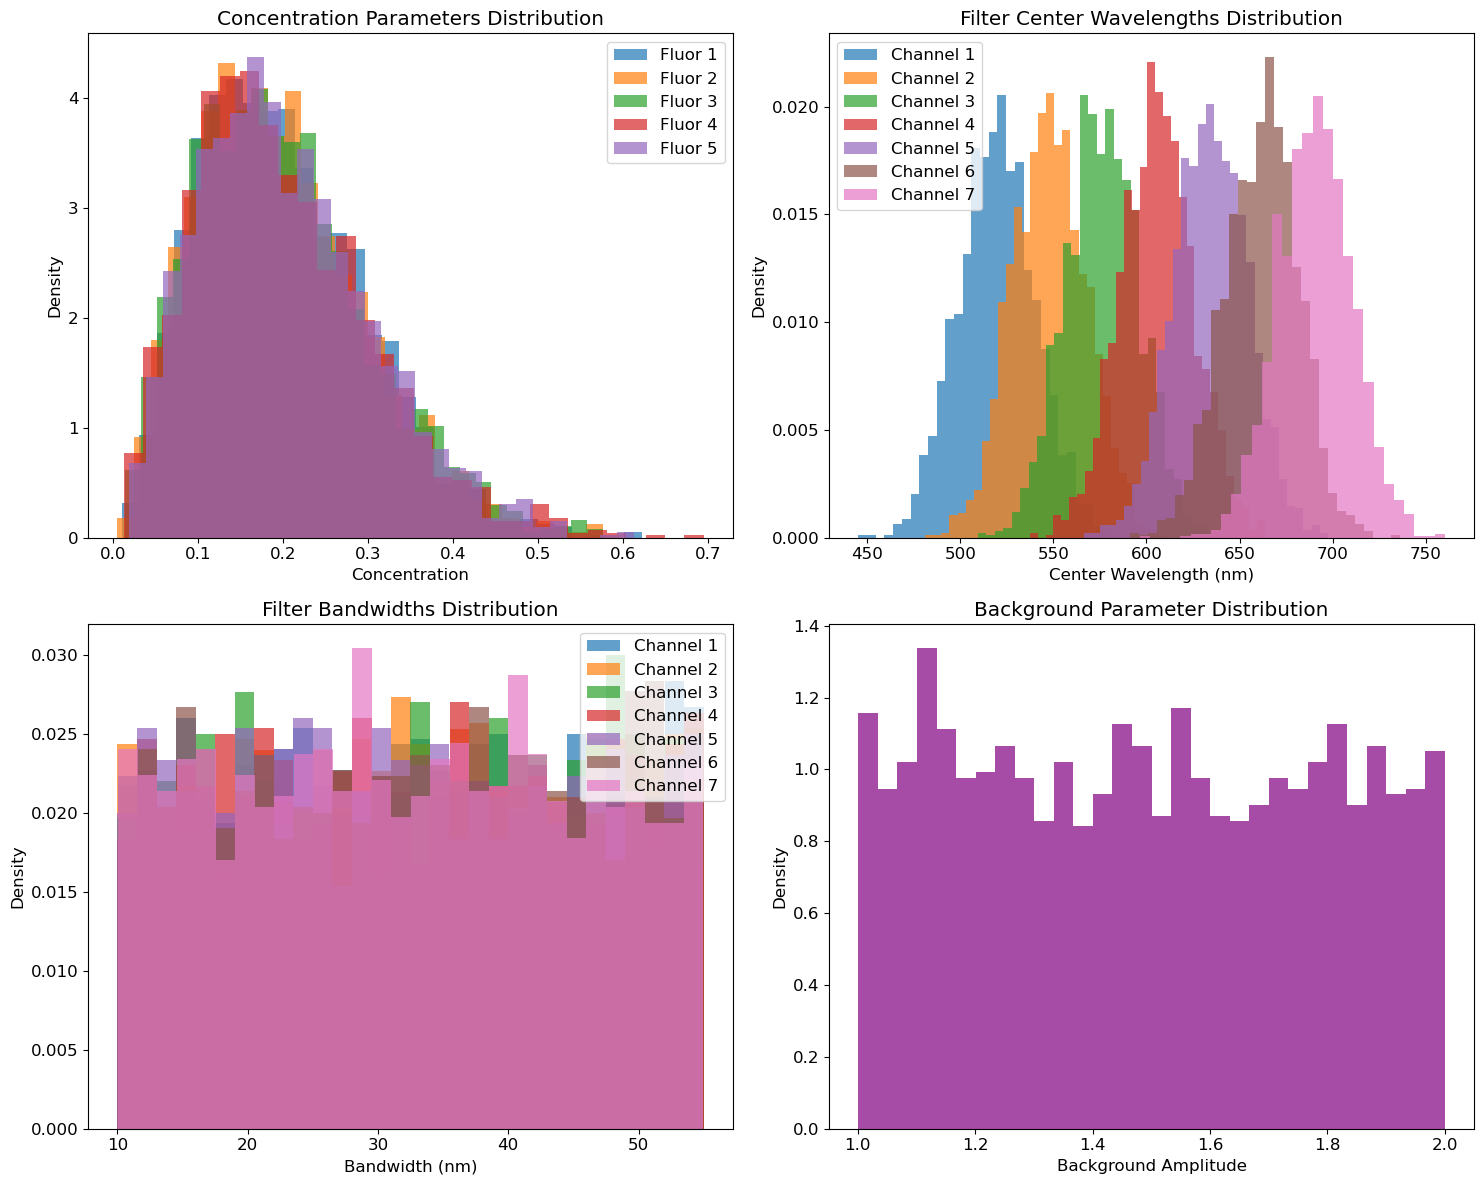

In [77]:
# Define prior configuration
prior_config = {
    'concentration': 3.0,  # Dirichlet concentration parameter
    'bandwidth_low': 10,
    'bandwidth_high': 55,
    'background_low': 1.0,
    'background_high': 2.0, 
}

# Create custom prior
prior = simulator.create_custom_prior(prior_config=prior_config)
# Generate samples from prior
n_samples = 50000
samples = prior.sample((n_samples,))
params = prior.extract_parameters(samples)

print("Sample shapes:")
for key, value in params.items():
    print(f"{key}: {value.shape}")

# Create visualizer
visualizer = PriorVisualizer(simulator)
visualizer.set_prior(prior)
# Plot prior distributions
fig1 = visualizer.plot_prior_distributions(n_samples=2000, figsize=(15, 12))
plt.show()

### Visualize an Example Filter Set from the Prior

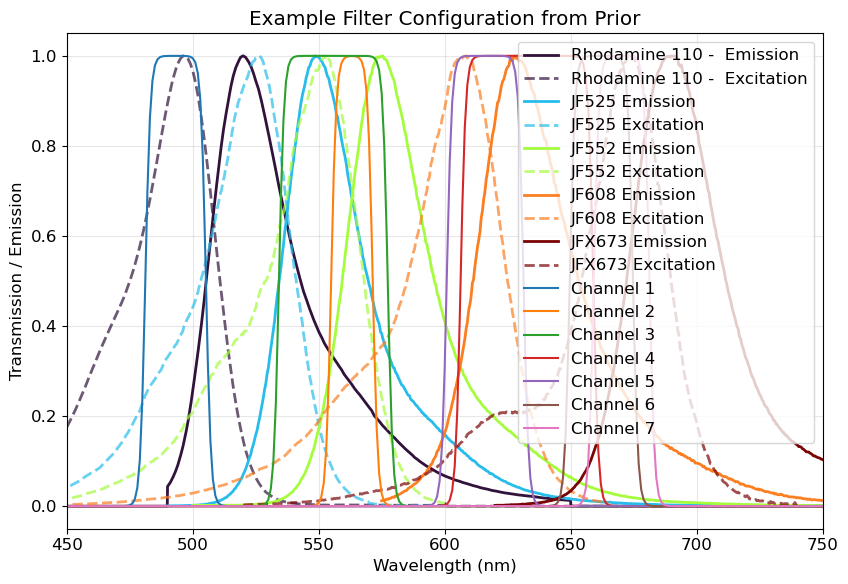

In [81]:
# Take one sample from the prior
sample_theta = prior.sample((1,))
sample_params = simulator.extract_parameters(sample_theta.numpy())
sample_centers = sample_params['center_wavelengths'][0]
sample_bandwidths = sample_params['bandwidths'][0]

# Create and plot the filters
example_filters = simulator.filter_bank.create_filters(sample_centers, sample_bandwidths)
plot_fluorophores(fluorophore_names, "../data/spectra_npz", normalize=True)

plt.Figure(figsize=(30, 16))
for i in range(sbi_config.n_channels):
    plt.plot(simulator.spectra_manager.wavelengths, example_filters[i], label=f'Channel {i+1}')

plt.title('Example Filter Configuration from Prior')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmission / Emission')
plt.legend()
plt.xlim(450, 750)  # Set x-axis limits for better visibility
plt.show()

## 5. Generate Training Data

We'll generate a dataset of parameter-observation pairs (`theta`, `x`). Each `theta` will include a set of concentrations and a corresponding set of filter parameters, all sampled from the prior.

In [14]:
n_simulations = 100000
print(f"Generating {n_simulations} training samples...")

theta_train, x_train = simulator.generate_training_data(
    n_samples=n_simulations,
    use_custom_prior=True
)

print(f"Generated theta_train with shape: {theta_train.shape}")
print(f"Generated x_train with shape: {x_train.shape}")

Generating 100000 training samples...
Generated theta_train with shape: torch.Size([100000, 20])
Generated x_train with shape: torch.Size([100000, 7])


## 6. Train the SBI Model

We use `sbi`'s `SNPE` (Sequential Neural Posterior Estimation) to train a model that learns the posterior distribution `p(theta | x)`.

In [15]:
print("Setting up the inference engine...")
inference = SNPE(prior=prior)

print("Appending simulations...")
inference.append_simulations(theta_train, x_train)

print("Training the density estimator...")
density_estimator = inference.train()

print("Building the posterior...")
posterior = inference.build_posterior(density_estimator)

print("Training complete!")

Setting up the inference engine...
Appending simulations...
Training the density estimator...
 Neural network successfully converged after 218 epochs.Building the posterior...
Training complete!


/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(


## 7. Evaluate the Posterior

Let's test our trained model. We'll generate a new, unseen observation and use the posterior to infer the parameters (`theta`) that produced it.

In [18]:
# Generate a single ground truth observation
theta_true, x_observation = simulator.generate_training_data(n_samples=1)
theta_true = theta_true[0]
x_observation = x_observation[0]

print("Ground Truth Parameters (theta_true):")
true_params = simulator.extract_parameters(theta_true.numpy())
for key, val in true_params.items():
    print(f"  {key}: {np.round(val, 2)}")

print(f"\nObservation (x_observation):\n  {x_observation.numpy().astype(int)}")

Ground Truth Parameters (theta_true):
  concentrations: [[0.16 0.21 0.03 0.03 0.57]]
  center_wavelengths: [[502.75 553.84 573.83 578.14 661.13 667.71 678.99]]
  bandwidths: [[36.73 25.41 26.03 29.47 25.86 39.69 33.06]]
  background: [[29.09]]

Observation (x_observation):
  [ 36  60  46  36  96 135 108]


In [19]:
# Sample from the posterior distribution
print("Sampling from the posterior...")
posterior_samples = posterior.sample((10000,), x=x_observation, show_progress_bars=True)

print(f"Generated {posterior_samples.shape[0]} posterior samples.")

Sampling from the posterior...


Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 73720.34it/s]

Generated 10000 posterior samples.


### Visualize the Inferred Posterior

In [21]:
# Generate 1,000 new test samples that weren't used in training
print("Generating held-out test set...")
n_test_samples = 50000
theta_test, x_test = simulator.generate_training_data(
    n_samples=n_test_samples, 
    use_custom_prior=True
)
print(f"Generated {n_test_samples} test samples")


Generating held-out test set...
Generated 50000 test samples


In [22]:
# Initialize storage for results
results_data = []

print("Evaluating posterior on test set...")
for i in range(n_test_samples):
    # Sample from posterior for this test observation
    posterior_samples = posterior.sample((500,), x=x_test[i], show_progress_bars=False)
    
    # Extract parameters using simulator.extract_parameters
    true_params = simulator.extract_parameters(theta_test[i:i+1].numpy())
    posterior_params = simulator.extract_parameters(posterior_samples.numpy())
    
    # Calculate centered R² for concentrations
    true_conc = true_params['concentrations'][0]
    pred_conc_mean = posterior_params['concentrations'].mean(axis=0)
    
    r_squared = simulator.calculate_r_squared(
        true_conc.reshape(1, -1), 
        pred_conc_mean.reshape(1, -1)
    )[0]
    
    # Store results
    results_data.append({
        'sample_idx': i,
        'true_center_wavelengths': true_params['center_wavelengths'][0],
        'true_bandwidths': true_params['bandwidths'][0],
        'true_concentrations': true_conc,
        'pred_concentrations': pred_conc_mean,
        'r_squared': r_squared
    })
    
    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1}/{n_test_samples} samples")


Evaluating posterior on test set...
Processed 100/50000 samples
Processed 200/50000 samples
Processed 300/50000 samples
Processed 400/50000 samples
Processed 500/50000 samples
Processed 600/50000 samples
Processed 700/50000 samples
Processed 800/50000 samples
Processed 900/50000 samples
Processed 1000/50000 samples
Processed 1100/50000 samples
Processed 1200/50000 samples
Processed 1300/50000 samples
Processed 1400/50000 samples
Processed 1500/50000 samples
Processed 1600/50000 samples
Processed 1700/50000 samples
Processed 1800/50000 samples
Processed 1900/50000 samples
Processed 2000/50000 samples
Processed 2100/50000 samples
Processed 2200/50000 samples
Processed 2300/50000 samples
Processed 2400/50000 samples
Processed 2500/50000 samples
Processed 2600/50000 samples
Processed 2700/50000 samples
Processed 2800/50000 samples
Processed 2900/50000 samples
Processed 3000/50000 samples
Processed 3100/50000 samples
Processed 3200/50000 samples
Processed 3300/50000 samples
Processed 3400/5

In [23]:
import pandas as pd

# Convert to DataFrame for analysis
df_results = pd.DataFrame(results_data)

# Expand filter parameters into separate columns
for i in range(sbi_config.n_channels):
    df_results[f'center_wl_ch{i+1}'] = df_results['true_center_wavelengths'].apply(lambda x: x[i])
    df_results[f'bandwidth_ch{i+1}'] = df_results['true_bandwidths'].apply(lambda x: x[i])

print(f"Created results DataFrame with {len(df_results)} rows")
print(f"Mean R² score: {df_results['r_squared'].mean():.3f}")


Created results DataFrame with 50000 rows
Mean R² score: 0.490


(array([3655., 1541., 1243., 1094.,  997.,  933.,  923.,  841.,  786.,
         780.,  750.,  788.,  790.,  774.,  746.,  801.,  796.,  799.,
         832.,  772.,  744.,  829.,  768.,  820.,  805.,  803.,  889.,
         846.,  863.,  880.,  903.,  925.,  870.,  960.,  977.,  993.,
        1052., 1024., 1036., 1031., 1111., 1148., 1127., 1170., 1150.,
        1169., 1208., 1294., 1107.,  857.]),
 array([1.18519443e-08, 1.99982207e-02, 3.99964303e-02, 5.99946417e-02,
        7.99928531e-02, 9.99910608e-02, 1.19989276e-01, 1.39987484e-01,
        1.59985691e-01, 1.79983899e-01, 1.99982107e-01, 2.19980314e-01,
        2.39978537e-01, 2.59976715e-01, 2.79974937e-01, 2.99973130e-01,
        3.19971353e-01, 3.39969575e-01, 3.59967768e-01, 3.79965991e-01,
        3.99964184e-01, 4.19962406e-01, 4.39960599e-01, 4.59958822e-01,
        4.79957044e-01, 4.99955237e-01, 5.19953430e-01, 5.39951682e-01,
        5.59949875e-01, 5.79948068e-01, 5.99946260e-01, 6.19944513e-01,
        6.39942706e-01, 

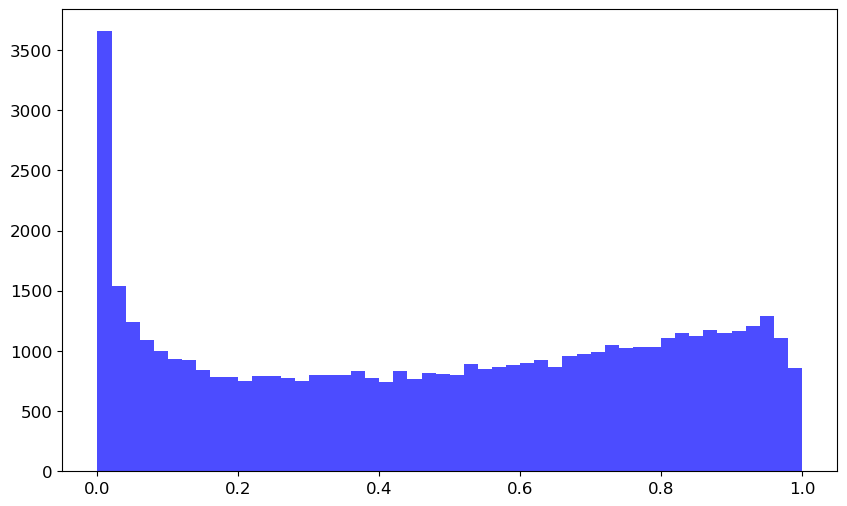

In [24]:
plt.hist(df_results['r_squared'], bins=50, color='blue', alpha=0.7)

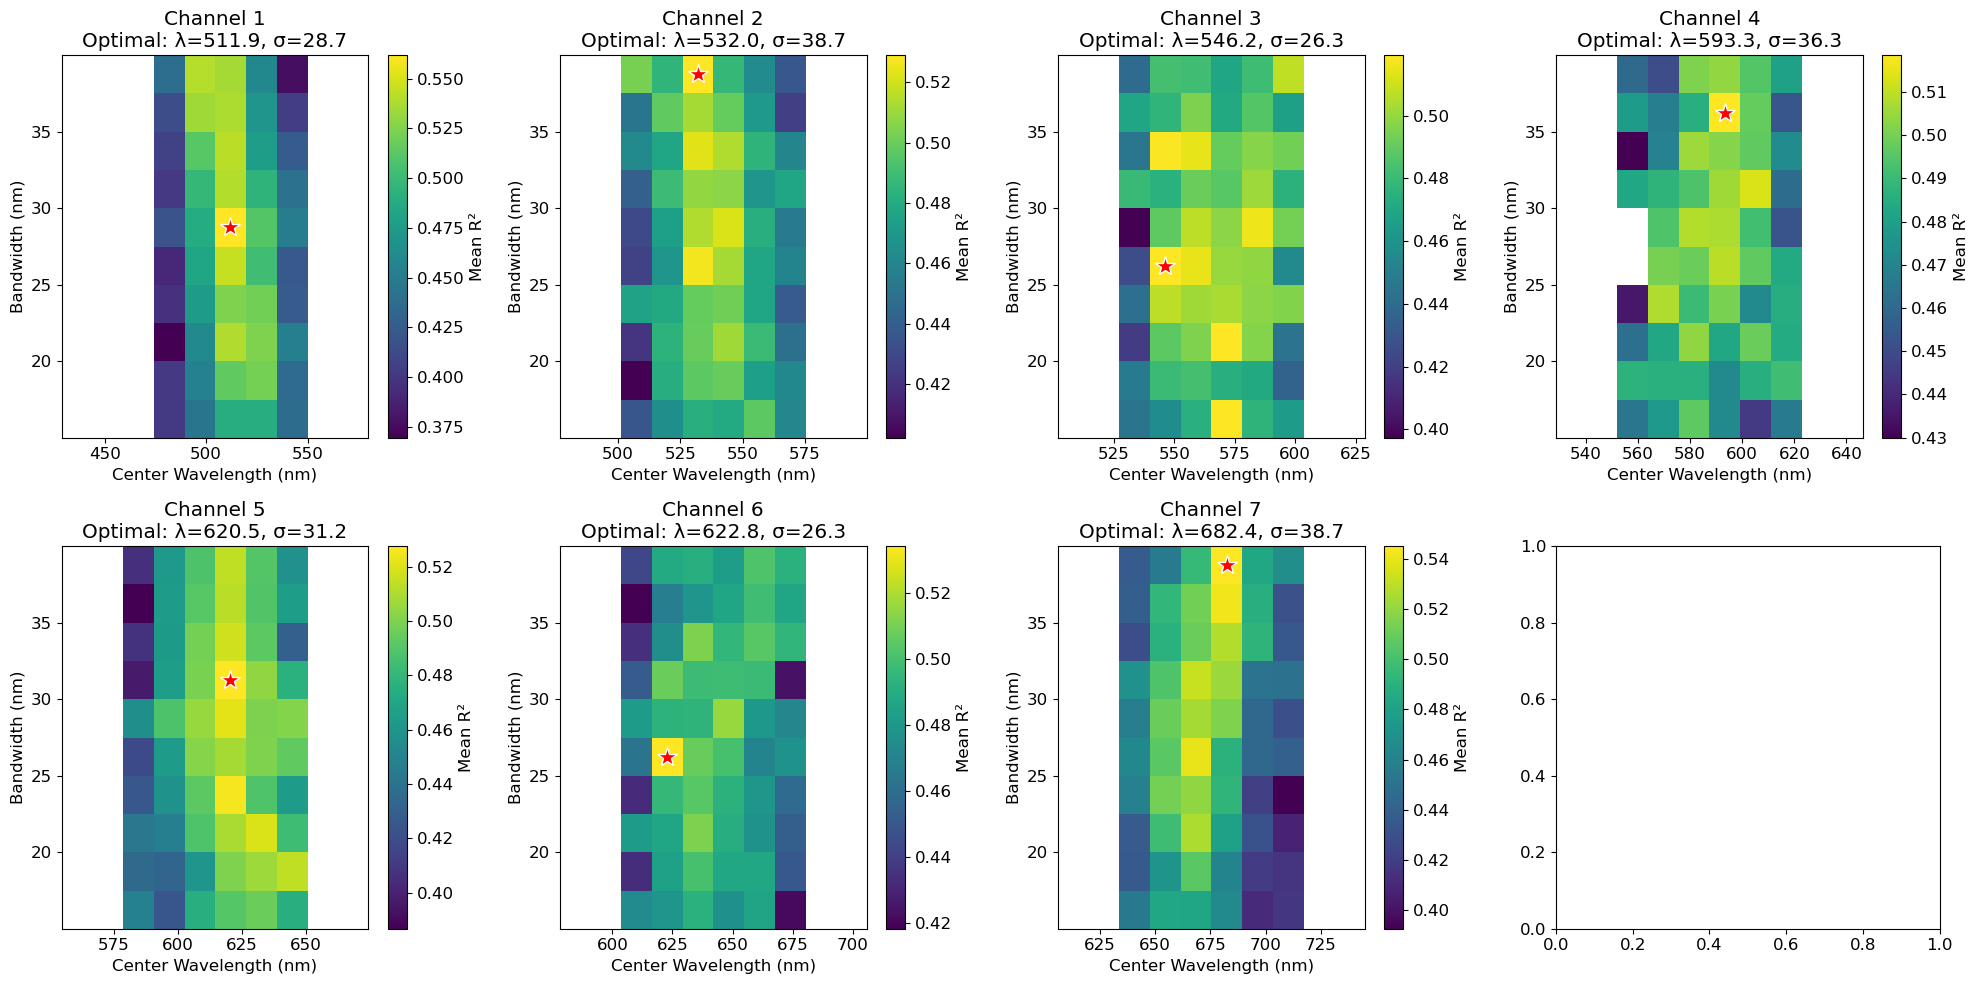

In [30]:
# Create 2D histograms for each channel
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

optimal_filters = {}
min_count = 120
for ch in range(sbi_config.n_channels):
    ax = axes[ch]
    
    # Get center wavelengths and bandwidths for this channel
    centers = df_results[f'center_wl_ch{ch+1}']
    bandwidths = df_results[f'bandwidth_ch{ch+1}']
    r_squared_vals = df_results['r_squared']
    
    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(
        centers, bandwidths, bins=10, weights=r_squared_vals
    )
    counts, _, _ = np.histogram2d(centers, bandwidths, bins=10)
    
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        mean_r_squared = np.divide(hist, counts, out=np.zeros_like(hist), where=counts!=0)
        mean_r_squared[counts < min_count] = np.nan  # Mask unreliable bins
    
    # Plot heatmap
    im = ax.imshow(mean_r_squared.T, origin='lower', aspect='auto', cmap='viridis',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    
    # Find optimal bin
    max_idx = np.unravel_index(np.nanargmax(mean_r_squared), mean_r_squared.shape)
    optimal_center = (xedges[max_idx[0]] + xedges[max_idx[0]+1]) / 2
    optimal_bandwidth = (yedges[max_idx[1]] + yedges[max_idx[1]+1]) / 2
    optimal_r_squared = mean_r_squared[max_idx]
    
    # Store optimal values
    optimal_filters[f'channel_{ch+1}'] = {
        'center_wavelength': optimal_center,
        'bandwidth': optimal_bandwidth,
        'r_squared': optimal_r_squared
    }
    
    # Mark optimal point
    ax.plot(optimal_center, optimal_bandwidth, 'r*', markersize=15, markeredgecolor='white')
    
    ax.set_xlabel('Center Wavelength (nm)')
    ax.set_ylabel('Bandwidth (nm)')
    ax.set_title(f'Channel {ch+1}\nOptimal: λ={optimal_center:.1f}, σ={optimal_bandwidth:.1f}')
    
    plt.colorbar(im, ax=ax, label='Mean R²')

plt.tight_layout()
plt.show()



ANALYZING R² DEPENDENCE ON DYE CONCENTRATIONS
Concentration matrix shape: (50000, 5)
Concentration ranges:
  JF479: 0.200 ± 0.164 (range: 0.000-0.958)
  JF525: 0.200 ± 0.163 (range: 0.000-0.920)
  JF552: 0.199 ± 0.163 (range: 0.000-0.917)
  JF608: 0.200 ± 0.163 (range: 0.000-0.935)
  JFX650: 0.200 ± 0.164 (range: 0.000-0.979)
Computing UMAP embedding for concentration space...


/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Concentration UMAP embedding complete!


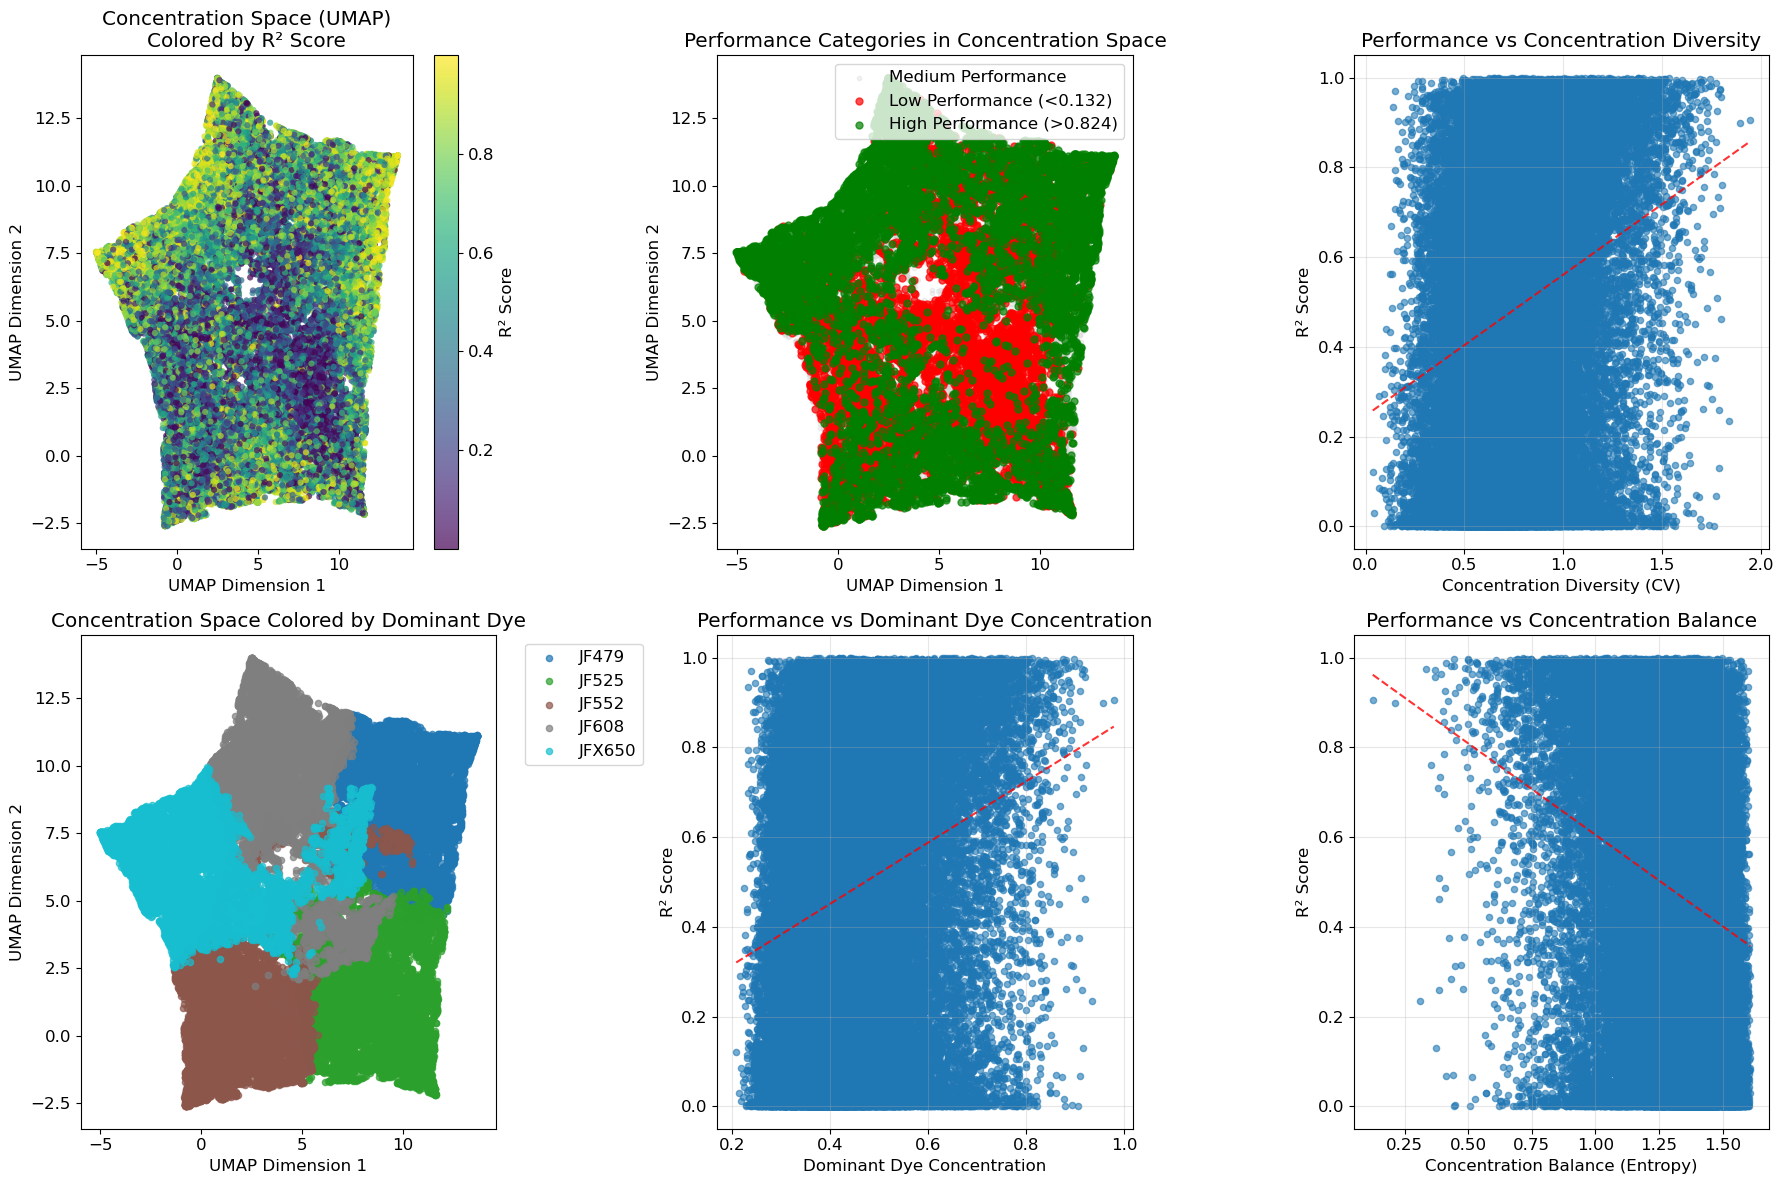

In [43]:
print("\n" + "="*60)
print("ANALYZING R² DEPENDENCE ON DYE CONCENTRATIONS")
print("="*60)

# Extract concentration data from all test samples
concentration_data = []
for i in range(len(df_results)):
    concentration_data.append(df_results.iloc[i]['true_concentrations'])

# Convert to numpy array
X_concentrations = np.array(concentration_data)
r2_scores = df_results['r_squared'].values

print(f"Concentration matrix shape: {X_concentrations.shape}")
print(f"Concentration ranges:")
for i, fluor_name in enumerate(fluorophore_names):
    conc_min, conc_max = X_concentrations[:, i].min(), X_concentrations[:, i].max()
    conc_mean, conc_std = X_concentrations[:, i].mean(), X_concentrations[:, i].std()
    print(f"  {fluor_name}: {conc_mean:.3f} ± {conc_std:.3f} (range: {conc_min:.3f}-{conc_max:.3f})")

# Standardize concentrations for UMAP
scaler_conc = StandardScaler()
X_conc_scaled = scaler_conc.fit_transform(X_concentrations)
# Configure UMAP for concentration space
umap_conc = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)

print("Computing UMAP embedding for concentration space...")
embedding_conc = umap_conc.fit_transform(X_conc_scaled)
print("Concentration UMAP embedding complete!")
# Create comprehensive concentration analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. UMAP of concentration space colored by R²
ax1 = axes[0, 0]
scatter1 = ax1.scatter(embedding_conc[:, 0], embedding_conc[:, 1], 
                      c=r2_scores, cmap='viridis', 
                      s=20, alpha=0.7, edgecolors='none')
ax1.set_xlabel('UMAP Dimension 1')
ax1.set_ylabel('UMAP Dimension 2')
ax1.set_title('Concentration Space (UMAP)\nColored by R² Score')
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('R² Score')

# 2. Highlight high/low performers
ax2 = axes[0, 1]
# Define performance thresholds
high_perf_threshold = np.percentile(r2_scores, 80)
low_perf_threshold = np.percentile(r2_scores, 20)

high_perf_mask = r2_scores >= high_perf_threshold
low_perf_mask = r2_scores <= low_perf_threshold
mid_perf_mask = ~(high_perf_mask | low_perf_mask)

ax2.scatter(embedding_conc[mid_perf_mask, 0], embedding_conc[mid_perf_mask, 1], 
           c='lightgray', s=10, alpha=0.3, label='Medium Performance')
ax2.scatter(embedding_conc[low_perf_mask, 0], embedding_conc[low_perf_mask, 1], 
           c='red', s=25, alpha=0.7, label=f'Low Performance (<{low_perf_threshold:.3f})')
ax2.scatter(embedding_conc[high_perf_mask, 0], embedding_conc[high_perf_mask, 1], 
           c='green', s=25, alpha=0.7, label=f'High Performance (>{high_perf_threshold:.3f})')
ax2.set_xlabel('UMAP Dimension 1')
ax2.set_ylabel('UMAP Dimension 2')
ax2.set_title('Performance Categories in Concentration Space')
ax2.legend()

# 3. Concentration diversity vs Performance
ax3 = axes[0, 2]
# Calculate concentration diversity (entropy or coefficient of variation)
conc_diversity = []
for i in range(len(X_concentrations)):
    conc = X_concentrations[i]
    # Use coefficient of variation as diversity measure
    diversity = np.std(conc) / (np.mean(conc) + 1e-8)
    conc_diversity.append(diversity)

conc_diversity = np.array(conc_diversity)
ax3.scatter(conc_diversity, r2_scores, alpha=0.6, s=20)
ax3.set_xlabel('Concentration Diversity (CV)')
ax3.set_ylabel('R² Score')
ax3.set_title('Performance vs Concentration Diversity')
ax3.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(conc_diversity, r2_scores, 1)
p = np.poly1d(z)
ax3.plot(sorted(conc_diversity), p(sorted(conc_diversity)), "r--", alpha=0.8)

# 4. Dominant dye analysis
ax4 = axes[1, 0]
# Find the dominant dye for each sample
dominant_dye_idx = np.argmax(X_concentrations, axis=1)
dominant_dye_conc = np.max(X_concentrations, axis=1)

# Color by dominant dye
colors_dye = plt.cm.tab10(np.linspace(0, 1, len(fluorophore_names)))
for i, fluor_name in enumerate(fluorophore_names):
    mask = dominant_dye_idx == i
    if np.any(mask):
        ax4.scatter(embedding_conc[mask, 0], embedding_conc[mask, 1], 
                   c=[colors_dye[i]], s=20, alpha=0.7, label=fluor_name)

ax4.set_xlabel('UMAP Dimension 1')
ax4.set_ylabel('UMAP Dimension 2')
ax4.set_title('Concentration Space Colored by Dominant Dye')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 5. Performance vs dominant concentration
ax5 = axes[1, 1]
ax5.scatter(dominant_dye_conc, r2_scores, alpha=0.6, s=20)
ax5.set_xlabel('Dominant Dye Concentration')
ax5.set_ylabel('R² Score')
ax5.set_title('Performance vs Dominant Dye Concentration')
ax5.grid(True, alpha=0.3)

# Add trend line
z2 = np.polyfit(dominant_dye_conc, r2_scores, 1)
p2 = np.poly1d(z2)
ax5.plot(sorted(dominant_dye_conc), p2(sorted(dominant_dye_conc)), "r--", alpha=0.8)

# 6. Concentration balance analysis
ax6 = axes[1, 2]
# Calculate how "balanced" the concentrations are (entropy)
from scipy.stats import entropy

conc_balance = []
for i in range(len(X_concentrations)):
    conc = X_concentrations[i]
    # Normalize to probabilities
    conc_norm = conc / (conc.sum() + 1e-8)
    # Calculate entropy (higher = more balanced)
    balance = entropy(conc_norm + 1e-8)
    conc_balance.append(balance)

conc_balance = np.array(conc_balance)
ax6.scatter(conc_balance, r2_scores, alpha=0.6, s=20)
ax6.set_xlabel('Concentration Balance (Entropy)')
ax6.set_ylabel('R² Score')
ax6.set_title('Performance vs Concentration Balance')
ax6.grid(True, alpha=0.3)

# Add trend line
z3 = np.polyfit(conc_balance, r2_scores, 1)
p3 = np.poly1d(z3)
ax6.plot(sorted(conc_balance), p3(sorted(conc_balance)), "r--", alpha=0.8)

plt.tight_layout()
plt.show()


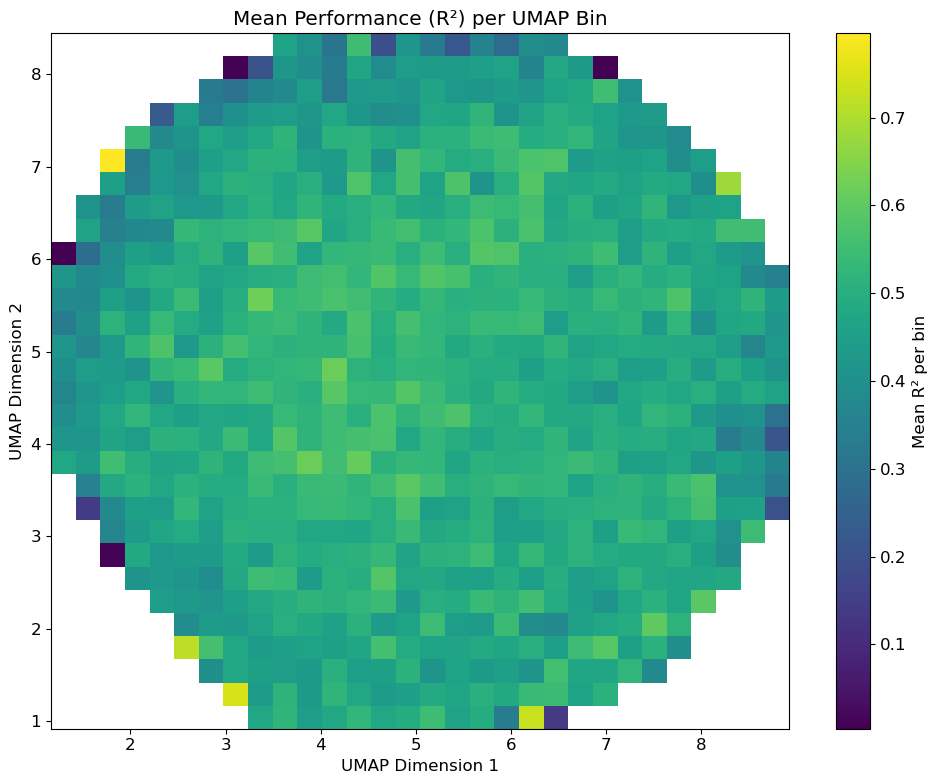

In [44]:
# 2D histogram: mean R² per UMAP bin

import numpy as np
import matplotlib.pyplot as plt

# Number of bins for UMAP dimensions
n_bins = 30

# Get UMAP embedding and R² scores
umap_x = embedding[:, 0]
umap_y = embedding[:, 1]
r2_scores = df_results['r_squared'].values

# Compute bin edges
x_edges = np.linspace(umap_x.min(), umap_x.max(), n_bins + 1)
y_edges = np.linspace(umap_y.min(), umap_y.max(), n_bins + 1)

# Digitize UMAP coordinates
x_bin = np.digitize(umap_x, x_edges) - 1
y_bin = np.digitize(umap_y, y_edges) - 1

# Initialize arrays for mean R² and counts
mean_r2_hist = np.full((n_bins, n_bins), np.nan)
counts_hist = np.zeros((n_bins, n_bins), dtype=int)

# Accumulate R² scores in bins
for i in range(len(r2_scores)):
    xb, yb = x_bin[i], y_bin[i]
    if 0 <= xb < n_bins and 0 <= yb < n_bins:
        if np.isnan(mean_r2_hist[xb, yb]):
            mean_r2_hist[xb, yb] = r2_scores[i]
            counts_hist[xb, yb] = 1
        else:
            mean_r2_hist[xb, yb] += r2_scores[i]
            counts_hist[xb, yb] += 1

# Compute mean R² per bin
with np.errstate(invalid='ignore'):
    mean_r2_hist = mean_r2_hist / np.maximum(counts_hist, 1)
    mean_r2_hist[counts_hist == 0] = np.nan  # Mask empty bins

# Plot heatmap
plt.figure(figsize=(10, 8))
plt.imshow(mean_r2_hist.T, origin='lower', aspect='auto',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           cmap='viridis')
plt.colorbar(label='Mean R² per bin')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('Mean Performance (R²) per UMAP Bin')
plt.tight_layout()
plt.show()

In [32]:
# Sort all test samples by R² performance
df_results_sorted = df_results.sort_values('r_squared', ascending=False)

# Get the top N% of best-performing filter combinations
top_percentile = 5  # Top 5% of configurations
n_top = int(len(df_results) * top_percentile / 100)
top_configs = df_results_sorted.head(n_top)

print(f"Analyzing top {n_top} filter combinations (top {top_percentile}%)")
print(f"R² range in top configs: {top_configs['r_squared'].min():.3f} - {top_configs['r_squared'].max():.3f}")


Analyzing top 2500 filter combinations (top 5%)
R² range in top configs: 0.951 - 1.000


In [33]:
# Get the absolute best configuration
best_config = df_results_sorted.iloc[0]
best_r_squared = best_config['r_squared']

print("=" * 60)
print("BEST JOINT FILTER CONFIGURATION")
print("=" * 60)
print(f"Best R² Score: {best_r_squared:.4f}")
print("\nOptimal Filter Settings:")

best_centers = best_config['true_center_wavelengths']
best_bandwidths = best_config['true_bandwidths']

for ch in range(sbi_config.n_channels):
    print(f"  Channel {ch+1}: λ={best_centers[ch]:.1f} nm, σ={best_bandwidths[ch]:.1f} nm")


BEST JOINT FILTER CONFIGURATION
Best R² Score: 0.9999

Optimal Filter Settings:
  Channel 1: λ=516.4 nm, σ=17.9 nm
  Channel 2: λ=567.0 nm, σ=18.5 nm
  Channel 3: λ=578.3 nm, σ=23.8 nm
  Channel 4: λ=582.9 nm, σ=28.4 nm
  Channel 5: λ=617.2 nm, σ=36.4 nm
  Channel 6: λ=662.4 nm, σ=28.1 nm
  Channel 7: λ=668.6 nm, σ=18.9 nm


In [39]:
# Create statistical summary of top-performing configurations
print("\n" + "=" * 60)
print("ANALYSIS OF TOP-PERFORMING CONFIGURATIONS")
print("=" * 60)

# Calculate statistics for each channel across top configurations
channel_stats = {}
for ch in range(sbi_config.n_channels):
    center_col = f'center_wl_ch{ch+1}'
    bandwidth_col = f'bandwidth_ch{ch+1}'
    
    channel_stats[f'channel_{ch+1}'] = {
        'center_mean': top_configs[center_col].mean(),
        'center_std': top_configs[center_col].std(),
        'center_range': (top_configs[center_col].min(), top_configs[center_col].max()),
        'bandwidth_mean': top_configs[bandwidth_col].mean(),
        'bandwidth_std': top_configs[bandwidth_col].std(),
        'bandwidth_range': (top_configs[bandwidth_col].min(), top_configs[bandwidth_col].max())
    }
    
    print(f"Channel {ch+1} (in top {top_percentile}% configs):")
    print(f"  Center λ: {channel_stats[f'channel_{ch+1}']['center_mean']:.1f} ± {channel_stats[f'channel_{ch+1}']['center_std']:.1f} nm")
    print(f"  Range: {channel_stats[f'channel_{ch+1}']['center_range'][0]:.1f} - {channel_stats[f'channel_{ch+1}']['center_range'][1]:.1f} nm")
    print(f"  Bandwidth: {channel_stats[f'channel_{ch+1}']['bandwidth_mean']:.1f} ± {channel_stats[f'channel_{ch+1}']['bandwidth_std']:.1f} nm")
    print(f"  Range: {channel_stats[f'channel_{ch+1}']['bandwidth_range'][0]:.1f} - {channel_stats[f'channel_{ch+1}']['bandwidth_range'][1]:.1f} nm")
    print()



ANALYSIS OF TOP-PERFORMING CONFIGURATIONS
Channel 1 (in top 5% configs):
  Center λ: 515.6 ± 15.6 nm
  Range: 459.8 - 567.3 nm
  Bandwidth: 28.4 ± 7.1 nm
  Range: 15.0 - 40.0 nm

Channel 2 (in top 5% configs):
  Center λ: 541.6 ± 14.5 nm
  Range: 501.1 - 586.5 nm
  Bandwidth: 27.4 ± 7.2 nm
  Range: 15.0 - 40.0 nm

Channel 3 (in top 5% configs):
  Center λ: 566.5 ± 14.5 nm
  Range: 518.5 - 615.2 nm
  Bandwidth: 26.9 ± 7.1 nm
  Range: 15.0 - 40.0 nm

Channel 4 (in top 5% configs):
  Center λ: 591.3 ± 14.1 nm
  Range: 549.1 - 638.2 nm
  Bandwidth: 27.5 ± 7.2 nm
  Range: 15.0 - 40.0 nm

Channel 5 (in top 5% configs):
  Center λ: 617.3 ± 14.3 nm
  Range: 568.6 - 668.9 nm
  Bandwidth: 28.0 ± 7.1 nm
  Range: 15.0 - 40.0 nm

Channel 6 (in top 5% configs):
  Center λ: 640.3 ± 14.0 nm
  Range: 599.3 - 684.3 nm
  Bandwidth: 27.7 ± 7.0 nm
  Range: 15.0 - 40.0 nm

Channel 7 (in top 5% configs):
  Center λ: 665.4 ± 14.9 nm
  Range: 622.2 - 717.5 nm
  Bandwidth: 27.0 ± 7.1 nm
  Range: 15.0 - 40.0 nm

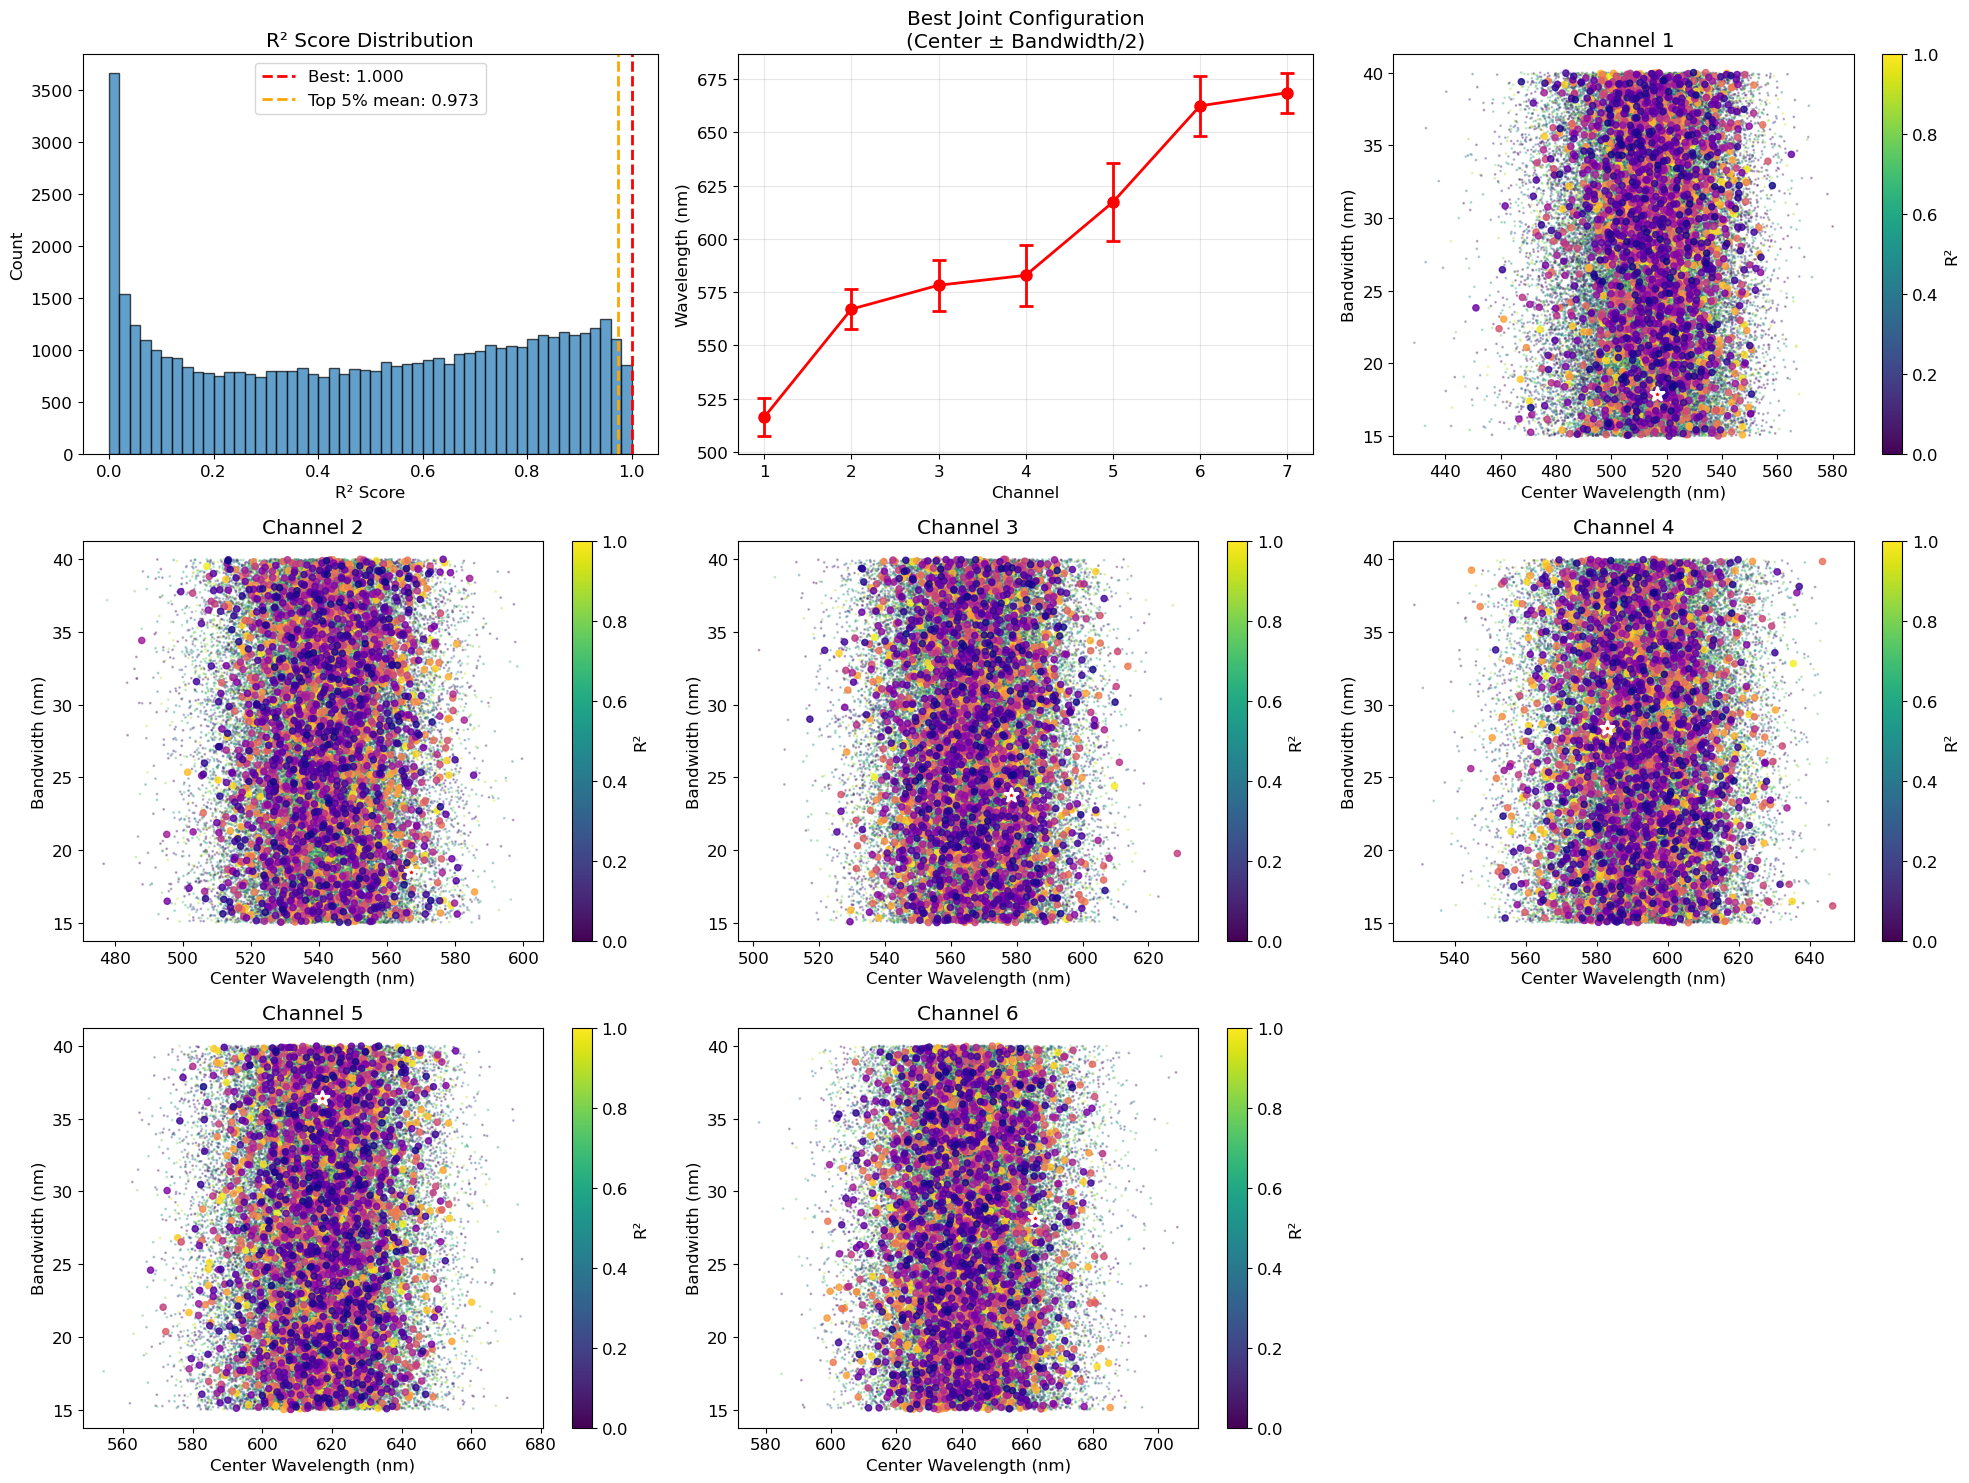

In [34]:
# Create comprehensive visualization
fig = plt.figure(figsize=(20, 15))

# 1. Performance distribution
ax1 = plt.subplot(3, 3, 1)
plt.hist(df_results['r_squared'], bins=50, alpha=0.7, edgecolor='black')
plt.axvline(best_r_squared, color='red', linestyle='--', linewidth=2, label=f'Best: {best_r_squared:.3f}')
plt.axvline(top_configs['r_squared'].mean(), color='orange', linestyle='--', linewidth=2, 
           label=f'Top {top_percentile}% mean: {top_configs["r_squared"].mean():.3f}')
plt.xlabel('R² Score')
plt.ylabel('Count')
plt.title('R² Score Distribution')
plt.legend()

# 2. Best configuration visualization
ax2 = plt.subplot(3, 3, 2)
channels = np.arange(1, sbi_config.n_channels + 1)
plt.errorbar(channels, [best_centers[i] for i in range(sbi_config.n_channels)], 
            yerr=[best_bandwidths[i]/2 for i in range(sbi_config.n_channels)], 
            fmt='ro-', capsize=5, capthick=2, linewidth=2, markersize=8)
plt.xlabel('Channel')
plt.ylabel('Wavelength (nm)')
plt.title('Best Joint Configuration\n(Center ± Bandwidth/2)')
plt.grid(True, alpha=0.3)

# 3-8. Channel-wise distributions for top configs
for ch in range(min(6, sbi_config.n_channels)):  # Show first 6 channels
    ax = plt.subplot(3, 3, ch + 3)
    
    # Plot all configs in light gray
    plt.scatter(df_results[f'center_wl_ch{ch+1}'], df_results[f'bandwidth_ch{ch+1}'], 
               c=df_results['r_squared'], cmap='viridis', alpha=0.3, s=1)
    
    # Highlight top configs
    plt.scatter(top_configs[f'center_wl_ch{ch+1}'], top_configs[f'bandwidth_ch{ch+1}'], 
               c=top_configs['r_squared'], cmap='plasma', s=20, alpha=0.8)
    
    # Mark the absolute best
    plt.scatter(best_centers[ch], best_bandwidths[ch], 
               c='red', s=100, marker='*', edgecolor='white', linewidth=2)
    
    plt.xlabel('Center Wavelength (nm)')
    plt.ylabel('Bandwidth (nm)')
    plt.title(f'Channel {ch+1}')
    plt.colorbar(label='R²')

plt.tight_layout()
plt.show()


In [35]:
print("\n" + "=" * 60)
print("VALIDATION: POSTERIOR SAMPLING WITH OPTIMAL CONFIGURATION")
print("=" * 60)

# Sample new concentrations from the same prior used in training
n_validation_tests = 1000  # Test on 10 different concentration profiles
validation_samples = prior.sample((n_validation_tests,))

print(f"Sampled {n_validation_tests} new concentration profiles from prior")

validation_results = []

for i in range(n_validation_tests):
    print(f"\nTesting concentration profile {i+1}:")
    
    # Create parameter vector with optimal filter configuration
    optimal_theta = validation_samples[i:i+1].clone()
    
    # Override filter parameters with optimal values (keep concentrations from prior)
    optimal_theta[0, simulator.center_slice] = torch.tensor(best_centers)
    optimal_theta[0, simulator.bandwidth_slice] = torch.tensor(best_bandwidths)
    
    # Extract the sampled concentrations for display
    sampled_params = simulator.extract_parameters(optimal_theta.numpy())
    sampled_conc = sampled_params['concentrations'][0]
    print(f"Sampled concentrations: {sampled_conc}")
    
    # Simulate observation with optimal configuration
    x_optimal = simulator.simulate_batch(optimal_theta.numpy(), add_noise=True)
    print(f"Simulated observation: {x_optimal.numpy()[0].astype(int)}")
    
    # Sample from posterior
    posterior_samples = posterior.sample((1000,), x=x_optimal[0], show_progress_bars=False)
    
    # Extract parameters
    true_params = simulator.extract_parameters(optimal_theta.numpy())
    posterior_params = simulator.extract_parameters(posterior_samples.numpy())
    
    # Calculate R² for concentrations
    true_conc = true_params['concentrations'][0]
    pred_conc_mean = posterior_params['concentrations'].mean(axis=0)
    pred_conc_std = posterior_params['concentrations'].std(axis=0)
    
    r_squared = simulator.calculate_r_squared(
        true_conc.reshape(1, -1), 
        pred_conc_mean.reshape(1, -1)
    )[0]
    
   
    
    validation_results.append({
        'profile': i+1,
        'true_concentrations': true_conc,
        'pred_concentrations': pred_conc_mean,
        'pred_std': pred_conc_std,
        'r_squared': r_squared,
        'observation': x_optimal[0].numpy()
    })

# Summary
mean_r2 = np.mean([r['r_squared'] for r in validation_results])
std_r2 = np.std([r['r_squared'] for r in validation_results])
print(f"\n" + "="*50)
print(f"VALIDATION SUMMARY")
print(f"="*50)
print(f"Mean R² across {n_validation_tests} test profiles: {mean_r2:.4f} ± {std_r2:.4f}")
print(f"Compared to training best: {mean_r2/best_r_squared:.3f}")
print(f"Range: {min([r['r_squared'] for r in validation_results]):.4f} - {max([r['r_squared'] for r in validation_results]):.4f}")

if mean_r2/best_r_squared > 0.9:
    print("✓ Excellent: Optimal configuration performs very well on new samples")
elif mean_r2/best_r_squared > 0.8:
    print("✓ Good: Optimal configuration performs well on new samples")
else:
    print("⚠ Moderate: Some performance drop on new samples")



VALIDATION: POSTERIOR SAMPLING WITH OPTIMAL CONFIGURATION
Sampled 1000 new concentration profiles from prior

Testing concentration profile 1:
Sampled concentrations: [0.21699317 0.04514247 0.34758034 0.19916435 0.19111969]
Simulated observation: [36 83 84 93 98 61 60]


/groups/spruston/home/moharb/sbi-DELTA/notebooks/../multiplex_sim/sbi_simulator_with_filters.py:516: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(results, dtype=torch.float32)



Testing concentration profile 2:
Sampled concentrations: [0.34938577 0.17392507 0.1740529  0.15879232 0.14384395]
Simulated observation: [80 80 94 93 83 60 45]

Testing concentration profile 3:
Sampled concentrations: [0.22641917 0.14033093 0.23488244 0.21995234 0.17841512]
Simulated observation: [49 51 72 65 79 86 54]

Testing concentration profile 4:
Sampled concentrations: [0.11447902 0.2741857  0.12918681 0.26799998 0.2141485 ]
Simulated observation: [ 33  63  55  82 105  94  47]

Testing concentration profile 5:
Sampled concentrations: [0.27883258 0.20545499 0.18886262 0.11469305 0.21215676]
Simulated observation: [58 72 82 91 48 75 39]

Testing concentration profile 6:
Sampled concentrations: [0.15840495 0.29990828 0.12522425 0.13031754 0.286145  ]
Simulated observation: [ 36  63  83  69  80 106  92]

Testing concentration profile 7:
Sampled concentrations: [0.27703825 0.12876971 0.1830698  0.23303863 0.17808361]
Simulated observation: [56 69 71 91 93 80 47]

Testing concentrati

KeyboardInterrupt: 

In [36]:
# Instead of just the single best, get the top percentile of configurations
top_percentile = 20  # Top 10% of configurations
df_results_sorted = df_results.sort_values('r_squared', ascending=False)
n_top = int(len(df_results) * top_percentile / 100)
top_configs = df_results_sorted.head(n_top)

print(f"Analyzing top {n_top} configurations (top {top_percentile}%)")
print(f"R² range in top configs: {top_configs['r_squared'].min():.3f} - {top_configs['r_squared'].max():.3f}")


Analyzing top 10000 configurations (top 20%)
R² range in top configs: 0.824 - 1.000


In [37]:


# Extract filter parameters from top configurations
filter_params = []
for ch in range(sbi_config.n_channels):
    filter_params.append(top_configs[f'center_wl_ch{ch+1}'].values)
    filter_params.append(top_configs[f'bandwidth_ch{ch+1}'].values)

# Create feature matrix: each row is a configuration, columns are [center1, bw1, center2, bw2, ...]
X = np.column_stack(filter_params)

# Standardize features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find optimal number of clusters using elbow method
from sklearn.metrics import silhouette_score

n_clusters_range = range(2, min(8, len(top_configs)//5))
silhouette_scores = []
inertias = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    inertias.append(kmeans.inertia_)

# Choose optimal number of clusters
optimal_n_clusters = n_clusters_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_n_clusters}")

# Perform final clustering
kmeans_final = KMeans(n_clusters=10, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to dataframe
top_configs_clustered = top_configs.copy()
top_configs_clustered['cluster'] = cluster_labels


Optimal number of clusters: 2


In [38]:
print("\n" + "="*60)
print("CLUSTER ANALYSIS OF TOP-PERFORMING CONFIGURATIONS")
print("="*60)

cluster_summaries = {}

for cluster_id in range(optimal_n_clusters):
    cluster_data = top_configs_clustered[top_configs_clustered['cluster'] == cluster_id]
    n_configs = len(cluster_data)
    
    print(f"\nCluster {cluster_id + 1}: {n_configs} configurations")
    print(f"  R² range: {cluster_data['r_squared'].min():.4f} - {cluster_data['r_squared'].max():.4f}")
    print(f"  Mean R²: {cluster_data['r_squared'].mean():.4f} ± {cluster_data['r_squared'].std():.4f}")
    
    # Analyze filter parameters for this cluster
    cluster_summary = {
        'n_configs': n_configs,
        'r2_mean': cluster_data['r_squared'].mean(),
        'r2_std': cluster_data['r_squared'].std(),
        'r2_min': cluster_data['r_squared'].min(),
        'r2_max': cluster_data['r_squared'].max(),
        'channels': {}
    }
    
    print("  Filter parameter ranges:")
    for ch in range(sbi_config.n_channels):
        center_col = f'center_wl_ch{ch+1}'
        bandwidth_col = f'bandwidth_ch{ch+1}'
        
        center_mean = cluster_data[center_col].mean()
        center_std = cluster_data[center_col].std()
        center_range = (cluster_data[center_col].min(), cluster_data[center_col].max())
        
        bandwidth_mean = cluster_data[bandwidth_col].mean()
        bandwidth_std = cluster_data[bandwidth_col].std()
        bandwidth_range = (cluster_data[bandwidth_col].min(), cluster_data[bandwidth_col].max())
        
        print(f"    Channel {ch+1}:")
        print(f"      Center: {center_mean:.1f} ± {center_std:.1f} nm (range: {center_range[0]:.1f}-{center_range[1]:.1f})")
        print(f"      Bandwidth: {bandwidth_mean:.1f} ± {bandwidth_std:.1f} nm (range: {bandwidth_range[0]:.1f}-{bandwidth_range[1]:.1f})")
        
        cluster_summary['channels'][f'ch{ch+1}'] = {
            'center_mean': center_mean,
            'center_std': center_std,
            'center_range': center_range,
            'bandwidth_mean': bandwidth_mean,
            'bandwidth_std': bandwidth_std,
            'bandwidth_range': bandwidth_range
        }
    
    cluster_summaries[cluster_id] = cluster_summary

# Identify the best cluster
best_cluster_id = max(cluster_summaries.keys(), key=lambda k: cluster_summaries[k]['r2_mean'])
best_cluster = cluster_summaries[best_cluster_id]

print(f"\n" + "="*40)
print(f"RECOMMENDED CLUSTER: Cluster {best_cluster_id + 1}")
print(f"="*40)
print(f"Contains {best_cluster['n_configs']} high-performing configurations")
print(f"Mean R²: {best_cluster['r2_mean']:.4f} ± {best_cluster['r2_std']:.4f}")



CLUSTER ANALYSIS OF TOP-PERFORMING CONFIGURATIONS

Cluster 1: 1059 configurations
  R² range: 0.8244 - 0.9997
  Mean R²: 0.9125 ± 0.0490
  Filter parameter ranges:
    Channel 1:
      Center: 516.3 ± 15.5 nm (range: 471.0-565.0)
      Bandwidth: 30.2 ± 6.5 nm (range: 15.0-40.0)
    Channel 2:
      Center: 553.5 ± 12.7 nm (range: 521.3-594.9)
      Bandwidth: 32.0 ± 6.1 nm (range: 15.1-40.0)
    Channel 3:
      Center: 577.5 ± 11.7 nm (range: 542.0-619.2)
      Bandwidth: 33.2 ± 4.9 nm (range: 16.0-40.0)
    Channel 4:
      Center: 598.5 ± 11.3 nm (range: 566.9-632.0)
      Bandwidth: 26.0 ± 6.6 nm (range: 15.0-39.9)
    Channel 5:
      Center: 618.4 ± 10.5 nm (range: 589.0-650.3)
      Bandwidth: 31.4 ± 6.3 nm (range: 15.1-40.0)
    Channel 6:
      Center: 637.9 ± 11.4 nm (range: 600.8-672.8)
      Bandwidth: 26.9 ± 7.1 nm (range: 15.0-40.0)
    Channel 7:
      Center: 664.7 ± 14.3 nm (range: 625.3-713.2)
      Bandwidth: 30.6 ± 6.5 nm (range: 15.0-40.0)

Cluster 2: 1136 config

In [39]:


print("Preparing filter parameter data for UMAP analysis...")

# Extract all filter parameters from all test samples (not just top ones)
filter_params_all = []
for ch in range(sbi_config.n_channels):
    filter_params_all.append(df_results[f'center_wl_ch{ch+1}'].values)
    filter_params_all.append(df_results[f'bandwidth_ch{ch+1}'].values)

# Create feature matrix: each row is a configuration, columns are [center1, bw1, center2, bw2, ...]
X_all = np.column_stack(filter_params_all)
r2_scores = df_results['r_squared'].values

print(f"Feature matrix shape: {X_all.shape}")
print(f"R² score range: {r2_scores.min():.4f} - {r2_scores.max():.4f}")

# Standardize features for UMAP
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)


Preparing filter parameter data for UMAP analysis...
Feature matrix shape: (50000, 14)
R² score range: 0.0000 - 0.9999


In [40]:
# Configure UMAP
umap_reducer = umap.UMAP(
    n_neighbors=15,      # Balance between local and global structure
    min_dist=0.1,        # Minimum distance between points in embedding
    n_components=2,      # 2D embedding
    metric='euclidean',  # Distance metric
    random_state=42      # Reproducibility
)

print("Computing UMAP embedding...")
embedding = umap_reducer.fit_transform(X_all)

print(f"UMAP embedding shape: {embedding.shape}")
print("UMAP embedding complete!")


Computing UMAP embedding...


/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (50000, 2)
UMAP embedding complete!


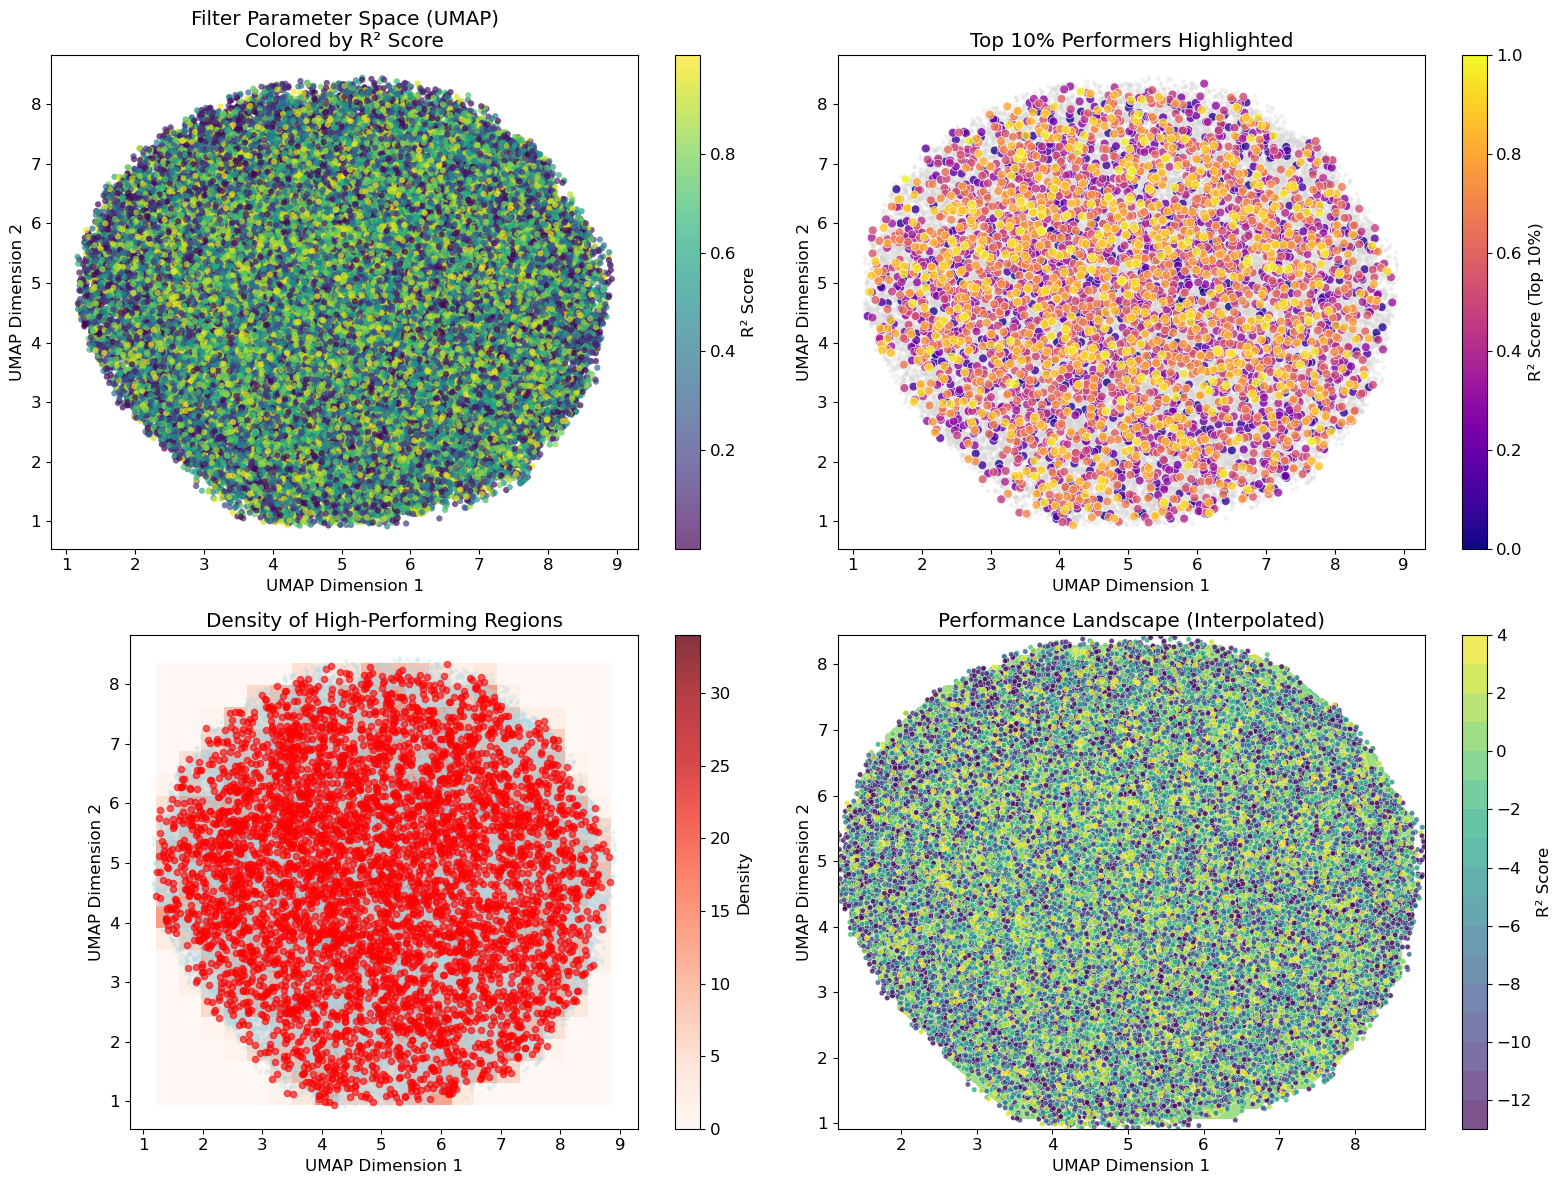

In [41]:
# Create comprehensive UMAP visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Main UMAP plot colored by R²
ax1 = axes[0, 0]
scatter = ax1.scatter(embedding[:, 0], embedding[:, 1], 
                     c=r2_scores, cmap='viridis', 
                     s=20, alpha=0.7, edgecolors='none')
ax1.set_xlabel('UMAP Dimension 1')
ax1.set_ylabel('UMAP Dimension 2')
ax1.set_title('Filter Parameter Space (UMAP)\nColored by R² Score')
cbar1 = plt.colorbar(scatter, ax=ax1)
cbar1.set_label('R² Score')

# 2. Highlight top performers
ax2 = axes[0, 1]
# Plot all points in light gray
ax2.scatter(embedding[:, 0], embedding[:, 1], 
           c='lightgray', s=10, alpha=0.3, edgecolors='none')

# Highlight top 10% in color
top_10_percent = int(len(df_results) * 0.1)
top_indices = np.argsort(r2_scores)[-top_10_percent:]
ax2.scatter(embedding[top_indices, 0], embedding[top_indices, 1], 
           c=r2_scores[top_indices], cmap='plasma', 
           s=40, alpha=0.8, edgecolors='white', linewidth=0.5)
ax2.set_xlabel('UMAP Dimension 1')
ax2.set_ylabel('UMAP Dimension 2')
ax2.set_title('Top 10% Performers Highlighted')
cbar2 = plt.colorbar(plt.cm.ScalarMappable(cmap='plasma'), ax=ax2)
cbar2.set_label('R² Score (Top 10%)')

# 3. Density plot of high performers
ax3 = axes[1, 0]
# Create 2D histogram of top performers
top_embedding = embedding[top_indices]
hist, xedges, yedges = np.histogram2d(top_embedding[:, 0], top_embedding[:, 1], bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax3.imshow(hist.T, origin='lower', extent=extent, cmap='Reds', alpha=0.8)
ax3.scatter(embedding[:, 0], embedding[:, 1], c='lightblue', s=5, alpha=0.2)
ax3.scatter(top_embedding[:, 0], top_embedding[:, 1], c='red', s=20, alpha=0.6)
ax3.set_xlabel('UMAP Dimension 1')
ax3.set_ylabel('UMAP Dimension 2')
ax3.set_title('Density of High-Performing Regions')
plt.colorbar(im, ax=ax3, label='Density')

# 4. Performance gradient
ax4 = axes[1, 1]
# Create contour plot showing performance landscape
from scipy.interpolate import griddata

# Create grid for interpolation
xi = np.linspace(embedding[:, 0].min(), embedding[:, 0].max(), 50)
yi = np.linspace(embedding[:, 1].min(), embedding[:, 1].max(), 50)
xi, yi = np.meshgrid(xi, yi)

# Interpolate R² scores onto grid
zi = griddata((embedding[:, 0], embedding[:, 1]), r2_scores, (xi, yi), method='cubic')

# Create contour plot
contour = ax4.contourf(xi, yi, zi, levels=15, cmap='viridis', alpha=0.7)
ax4.scatter(embedding[:, 0], embedding[:, 1], c=r2_scores, 
           cmap='viridis', s=15, alpha=0.8, edgecolors='white', linewidth=0.3)
ax4.set_xlabel('UMAP Dimension 1')
ax4.set_ylabel('UMAP Dimension 2')
ax4.set_title('Performance Landscape (Interpolated)')
plt.colorbar(contour, ax=ax4, label='R² Score')

plt.tight_layout()
plt.show()


Pareto configs found: 0
Empty DataFrame
Columns: [mean, std, count]
Index: []


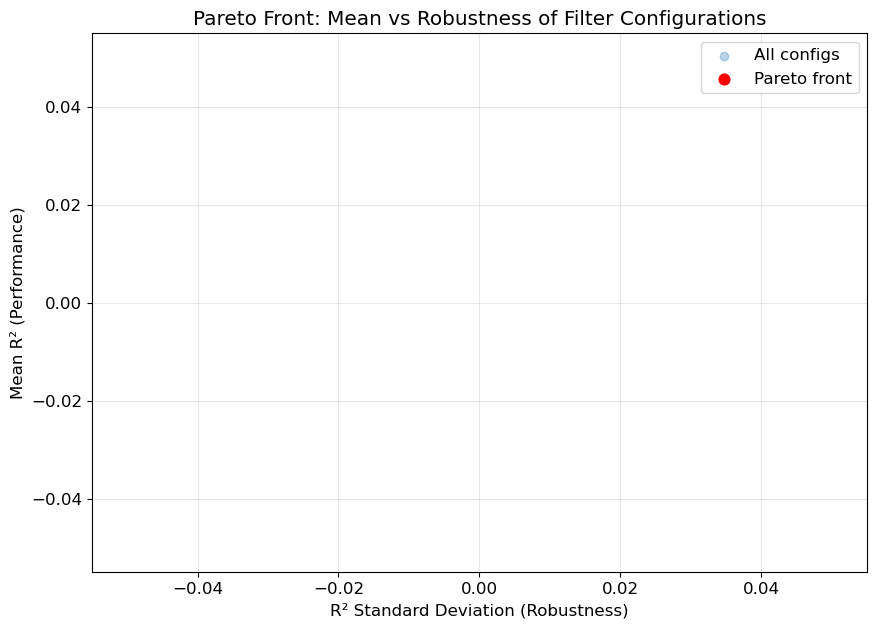

Top Pareto filter configurations (mean R², std R²):
Empty DataFrame
Columns: [mean, std, count]
Index: []


In [46]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Group by filter configuration (center + bandwidth for all channels)
# We'll round to avoid floating point issues
def round_params(row, decimals=1):
    return tuple(np.round(np.concatenate([row[f'center_wl_ch{i+1}'], row[f'bandwidth_ch{i+1}']]), decimals=decimals) for i in range(sbi_config.n_channels))

df_results['filter_key'] = df_results.apply(
    lambda row: tuple(np.round(
        np.concatenate([row['true_center_wavelengths'], row['true_bandwidths']]), 1
    )), axis=1
)

# 2. Aggregate mean and std R² for each filter configuration
agg = df_results.groupby('filter_key')['r_squared'].agg(['mean', 'std', 'count']).reset_index()
agg = agg[agg['count'] > 10]  # Only keep configs with enough samples

# 3. Pareto front calculation
def pareto_front(df):
    is_pareto = np.ones(df.shape[0], dtype=bool)
    for i, (mean_i, std_i) in enumerate(zip(df['mean'], df['std'])):
        # Exclude self-comparison
        others = df.drop(i)
        # A config is dominated if another has mean >= and std <= (and at least one strictly better)
        is_dominated = ((others['mean'] >= mean_i) & (others['std'] <= std_i) & 
                        ((others['mean'] > mean_i) | (others['std'] < std_i))).any()
        if is_dominated:
            is_pareto[i] = False
    return is_pareto

pareto_mask = pareto_front(agg)
pareto_configs = agg[pareto_mask]

print("Pareto configs found:", len(pareto_configs))
print(pareto_configs[['mean', 'std', 'count']].sort_values('mean', ascending=False).head(10))

# 4. Plot mean vs std R², highlight Pareto front
plt.figure(figsize=(10, 7))
plt.scatter(agg['std'], agg['mean'], alpha=0.3, label='All configs')
plt.scatter(pareto_configs['std'], pareto_configs['mean'], color='red', s=60, label='Pareto front')
plt.xlabel('R² Standard Deviation (Robustness)')
plt.ylabel('Mean R² (Performance)')
plt.title('Pareto Front: Mean vs Robustness of Filter Configurations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Optionally, print the top Pareto configurations
print("Top Pareto filter configurations (mean R², std R²):")
print(pareto_configs[['mean', 'std', 'count']].sort_values('mean', ascending=False).head(10))

In [82]:
import numpy as np

# Bin both center wavelengths and bandwidths for all channels
bin_size_center = 30  # nm
bin_size_bandwidth = 20  # nm

def bin_filter_params(row):
    centers = np.array(row['true_center_wavelengths'])
    bandwidths = np.array(row['true_bandwidths'])
    # Bin centers and bandwidths
    center_bins = (centers // bin_size_center).astype(int)
    bandwidth_bins = (bandwidths // bin_size_bandwidth).astype(int)
    # Combine into a tuple for grouping
    return tuple(np.concatenate([center_bins, bandwidth_bins]))

df_results['filter_bin_key'] = df_results.apply(bin_filter_params, axis=1)

# Check binning results
print("Number of unique filter_bin_key values:", df_results['filter_bin_key'].nunique())
print("Total rows:", len(df_results))

# Aggregate mean and std R² for each binned filter configuration
agg_bin = df_results.groupby('filter_bin_key')['r_squared'].agg(['mean', 'std', 'count']).reset_index()
print("Number of binned configs:", len(agg_bin))
print(agg_bin[['mean', 'std', 'count']].describe())

# Optionally, show some configs with multiple samples
print(agg_bin[agg_bin['count'] > 1].sort_values('count', ascending=False).head(10))

Number of unique filter_bin_key values: 17511
Total rows: 50000
Number of binned configs: 17511
               mean          std         count
count  1.751100e+04  7029.000000  17511.000000
mean   4.533449e-01     0.281464      2.855348
std    2.744773e-01     0.139341      6.429944
min    5.684779e-08     0.000207      1.000000
25%    2.284060e-01     0.186860      1.000000
50%    4.639401e-01     0.292274      1.000000
75%    6.549874e-01     0.367700      2.000000
max    9.997022e-01     0.698229    231.000000
                                          filter_bin_key      mean       std  \
12973  (17, 18, 18, 19, 20, 21, 22, 1, 1, 1, 1, 1, 1, 1)  0.578612  0.294552   
9717   (17, 17, 18, 19, 20, 21, 22, 1, 1, 1, 1, 1, 1, 1)  0.608287  0.297365   
14477  (17, 18, 19, 19, 20, 21, 22, 1, 1, 1, 1, 1, 1, 1)  0.568079  0.300658   
3259   (16, 17, 18, 19, 20, 21, 22, 1, 1, 1, 1, 1, 1, 1)  0.576611  0.296871   
5935   (16, 18, 18, 19, 20, 21, 22, 1, 1, 1, 1, 1, 1, 1)  0.572004  0.294816   
1

In [52]:
df_results['filter_bin_key'].values[:10]  # Show first 10 binned keys for verification


array([(np.int64(51), np.int64(56), np.int64(56), np.int64(58), np.int64(60), np.int64(64), np.int64(67), np.int64(7), np.int64(6), np.int64(5), np.int64(4), np.int64(6), np.int64(3), np.int64(6)),
       (np.int64(50), np.int64(54), np.int64(56), np.int64(59), np.int64(62), np.int64(63), np.int64(68), np.int64(5), np.int64(3), np.int64(5), np.int64(3), np.int64(3), np.int64(5), np.int64(7)),
       (np.int64(50), np.int64(52), np.int64(54), np.int64(57), np.int64(58), np.int64(62), np.int64(68), np.int64(5), np.int64(6), np.int64(3), np.int64(3), np.int64(5), np.int64(5), np.int64(6)),
       (np.int64(51), np.int64(52), np.int64(56), np.int64(58), np.int64(62), np.int64(63), np.int64(69), np.int64(6), np.int64(5), np.int64(3), np.int64(3), np.int64(7), np.int64(5), np.int64(4)),
       (np.int64(51), np.int64(53), np.int64(54), np.int64(59), np.int64(62), np.int64(63), np.int64(67), np.int64(7), np.int64(6), np.int64(3), np.int64(3), np.int64(3), np.int64(6), np.int64(4)),
       (np